In [9]:
import folium
import numpy as np
import os
import pandas as pd

from plotnine import *

path = os.getcwd()

def read_data():
    df1 = pd.read_excel('./public-crash-data.xlsx', sheet_name='2007-2015',
                        usecols=[3, 4, 5, 8], names=['date', 'lat', 'lon', 'sev'])
    df2 = pd.read_excel('./public-crash-data.xlsx', sheet_name='2016-2018',
                        usecols=[3, 4, 5, 8], names=['date', 'lat', 'lon', 'sev'])
    # join data sets
    df = df1.append(df2).reset_index()
    # remove rows with missing data, then convert lat/lon to numeric
    df = df[df.lon != '.']
    df['lat'] = df['lat'].astype(float)
    df['lon'] = df['lon'].astype(float)
    # with data converted, remove any rows missing lat/lon
    df = df[df.lat != 0]
    # save out in .csv for faster future reads
    df.to_csv('public-crash-data.csv', index=False)

# run this if input changes
#read_data()
df = pd.read_csv('public-crash-data.csv', converters={'date': pd.to_datetime})

In [2]:
### creating some boundaries for maps, and filtering to data on the bridge in the target date range
# top and bottom of bridge converted from Google Earth via https://gps-coordinates.org/coordinate-converter.php
top_lat, top_lon = (44.95254, -93.08239)
bot_lat, bot_lon = (44.93950, -93.07538)

# map bounding box corners: [southwest, northeast]
bbox = [[bot_lat+0.001, top_lon+0.0025], [top_lat-0.001, bot_lon+0.0025]]

# two markers placed on the left and right of bridge, subtracted to obtain the width (+ a little buffer)
left_lat, left_lon = (44.94633, -93.07944)
right_lat, right_lon = (44.94633, -93.07844)
width = abs(left_lon-right_lon)*1.1

# only count points if they were before construction started, or after it finished
def point_in_dates(date):
    if date < pd.datetime(year=2011, month=1, day=1) or date > pd.datetime(year=2016, month=4, day=1):
        return True
    return False


# is the point within the top/bottom of the bridge?
# if so, find the bridge lon at that lat and see if the point is within lon +/- width/2
def point_in_bounds(lat, lon):
    if not (lat>bot_lat and lat<top_lat):
        return False
    
    #lon_1 = (lat_1-lat_0)/m + lon_0
    slope = (top_lat-bot_lat)/(top_lon-bot_lon)
    lon_min = ((lat-bot_lat)/slope) + bot_lon - (width/2)
    lon_max = ((lat-bot_lat)/slope) + bot_lon + (width/2)

    if not (lon>lon_min and lon<lon_max):
        return False
    
    return True

# construct a df of only points in the date/location bounds fo rfuture calculations
df_in = pd.DataFrame(columns=['date', 'lat', 'lon', 'sev'])
for i, row in df.iterrows():
    if not point_in_dates(row.date):
        continue
    if not point_in_bounds(row.lat, row.lon):
        continue
    df_in = df_in.append(row)
df_in = df_in.sort_values('date')
df_in = df_in.reset_index(drop=True)
df_in.head()

,date,lat,lon,sev
0,2007-01-28,44.940367,-93.075964,5
1,2007-02-15,44.940536,-93.076059,5
2,2007-03-10,44.940536,-93.076059,5
3,2007-03-12,44.939836,-93.075501,5
4,2007-03-17,44.942693,-93.077272,5


In [7]:
### making the map
# create map object and fit to target area
m = folium.Map(location=[left_lat, left_lon], zoom_control=False,
               tiles='cartodbpositron', width=550, height=550)
m.fit_bounds(bounds=bbox)

# helper function to spit out circles
def make_circle(lat, lon, radius, fill_opacity, date):
    c = folium.Circle(location=[lat, lon], radius=radius, fill=True, stroke=False, fill_opacity=fill_opacity,
                  fill_color='blue' if date < pd.datetime(year=2016, month=4, day=1) else 'red')
    return c

# create a legend for colors/dates
legend_html = """<div style="font-family: hack; color: black; font-size: 1.5em; width: 280px; background-color: white; padding: 5px 5px 5px 5px;">
<span style="border-radius: 50%; height: 15px; width: 15px; background-color: blue; display: inline-block"></span>
<strong> old bridge</strong><br/>2007-01-28 to 2010-12-28<br/>205 crashes/1430 days <br/>0.143 crashes/day<br/>
<br/>
<span style="border-radius: 50%; height: 15px; width: 15px; background-color: red; display: inline-block"></span>
<strong> new bridge</strong><br/>2016-04-03 to 2018-12-26<br/>391 crashes/997 days <br/>0.392 crashes/day<br/>
</div>"""
legend = folium.Marker(location=[44.9538, -93.0769],
                       icon=folium.DivIcon(html=legend_html))
#legend.add_to(m)

# now add a point for each row in the data
for i, row in df_in.iterrows():
    # uncomment to specifically view crashes with serious injury
    #if not row.sev == 2:
    #    continue
    c = make_circle(lat=row.lat, lon=row.lon, radius=15, fill_opacity=0.3, date=row.date)
    c.add_to(m)
m

In [10]:
### saves out the map above to png via selenium screenshot
import subprocess
import time
from selenium import webdriver

### making the map
# create map object and fit to target area
m = folium.Map(location=[left_lat, left_lon], zoom_control=False,
               tiles='cartodbpositron', width=650, height=550)
m.fit_bounds(bounds=bbox)
legend = folium.Marker(location=[44.9538, -93.0749],
                       icon=folium.DivIcon(html=legend_html))
legend.add_to(m)

# helper function to spit out circles
def make_circle(lat, lon, radius, fill_opacity, date):
    c = folium.Circle(location=[lat, lon], radius=radius, fill=True, stroke=False, fill_opacity=fill_opacity,
                  fill_color='blue' if date < pd.datetime(year=2016, month=4, day=1) else 'red')
    return c

# now add a point for each row in the data
for i, row in df_in.iterrows():
    # uncomment to specifically view crashes with serious injury
    #if not row.sev == 2:
    #    continue
    c = make_circle(lat=row.lat, lon=row.lon, radius=15, fill_opacity=0.3, date=row.date)
    c.add_to(m)
m
browser = webdriver.Firefox()
browser.set_window_size(650, 625)

m.save('{}/map.html'.format(path))
browser.get('file://{}/map.html'.format(path))
time.sleep(3)
browser.save_screenshot('{}/pics/{}.png'.format(path, 'crashes-in-region'))
browser.quit()

In [5]:
### create dataframe copy, code by before/after, bin dates by year-quarter
df2 = df_in.copy()
df2['state'] = np.where(df2['date']<pd.datetime(year=2011, month=1, day=1), 'before', 'after')
df2['state'] = df2['state'].astype('category')
df2['state'] = df2['state'].cat.reorder_categories(['before', 'after'])
df2['x'] = df2['date'].dt.year.astype('str') + '-Q' + df2['date'].dt.quarter.astype('str')
df2.head()

,date,lat,lon,sev,state,x
0,2007-01-28,44.940367,-93.075964,5,before,2007-Q1
1,2007-02-15,44.940536,-93.076059,5,before,2007-Q1
2,2007-03-10,44.940536,-93.076059,5,before,2007-Q1
3,2007-03-12,44.939836,-93.075501,5,before,2007-Q1
4,2007-03-17,44.942693,-93.077272,5,before,2007-Q1


In [6]:
### look at crash totals and rate before vs. after bridge project
df_summ = df2.groupby('state', as_index=False).agg({'date': ['count', 'min', 'max']})
df_summ['delta'] = (df_summ['date']['max']-df_summ['date']['min']).dt.days
df_summ['rate'] = df_summ['date']['count']/df_summ['delta']
print(float(df_summ.iloc[1].rate/df_summ.iloc[0].rate))
df_summ


2.735670425911882


state  date                       delta      rate
          count        min        max                
0  before   205 2007-01-28 2010-12-28  1430  0.143357
1   after   391 2016-04-03 2018-12-26   997  0.392177

/home/jwhendy/.local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/jwhendy/.local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: accidents-before-vs-after.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


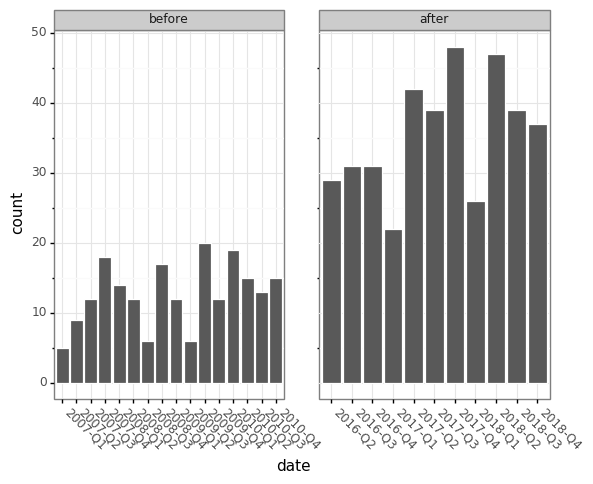

<ggplot: (8790800184081)>

In [7]:
### bar plot of crashes by quarter
p = ggplot(df2, aes(x='x')) + geom_bar(color='white', position='dodge') + facet_wrap('~state', scales='free_x')
p = p + scale_x_discrete(name='date')
p = p + theme_bw() + theme(axis_text_x=element_text(angle=315, hjust=0), subplots_adjust={'wspace': 0.15})
p.save('crashes-before-vs-after.png', dpi=150, width=10, height=6)
p

In [8]:
### statistics on severity
df2_sev = df2.groupby(['state', 'sev']).agg({'date': 'count'})
df2_sev['perc'] = df2_sev.groupby(level=0).date.apply(lambda x: x/x.sum())
df2_sev = df2_sev.reset_index()
df2_sev.columns = ['state', 'sev', 'count', 'percent']
df2_sev

,state,sev,count,percent
0,before,2,1,0.004878
1,before,3,11,0.053659
2,before,4,49,0.239024
3,before,5,144,0.702439
4,after,2,4,0.010230
5,after,3,11,0.028133
6,after,4,96,0.245524
7,after,5,280,0.716113
